# Step 1: Calibrate Camera

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import math
%matplotlib inline

In [2]:
def calibrate_camera(input_dir, num_images, width, height):
    """ Returns the camera calibration parameters.
    
    Parameters:
    ----------
    input_dir : str
        The directory containing chessboard images
    width : int
        The number of internal corners across one row of a chessboard.
    height : int
        The number of internal corners across one column of a chessboard.
    
    Returns
    -------
    tuple
        Tuple of the camera matrix and distortion coefficients.
     
    """
    fig = plt.figure(figsize=(16,20))
    cols = 2
    objpoints = []
    imgpoints = []
    # 3 dimensional coordinates, all with z = 0
    objp = np.zeros((height*width, 3), np.float32)
    # (x,y) coords
    objp[:,:2] = np.mgrid[0:width,0:height].T.reshape(-1,2)
    
    for img_number, img_name in enumerate(os.listdir(input_dir), start=1):
        img = mpimg.imread(input_dir + img_name)
        fig.add_subplot(num_images, cols, 2 * img_number - 1)
        plt.imshow(img)
        # convert to grayscale, mpimg uses RGB colors
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (width, height), None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            
            # draw and display corners
            img = cv2.drawChessboardCorners(img, (width, height), corners, ret)
            fig.add_subplot(num_images, cols, 2 * img_number)
            plt.imshow(img)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist

In [3]:
def undistort_img(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

def undistort_images(input_dir, output_dir, num_images, mtx, dist):
    """ Prints out the undistorted images.
    
    Parameters:
    ----------
    input_dir : str
        The directory containing the images to be undistorted.
    output_dir : str
        The directory to save the undistorted images.
    num_images : int
        Number of images in input_dir.
    mtx : array
        2-D camera matrix.
    dist : array
        2-D distortion matrix
    
    Returns
    -------
    something?
     
    """
    fig = plt.figure(figsize=(16,20))
    cols = 2
    for img_number, img_name in enumerate(os.listdir(input_dir), start=1):
        img = mpimg.imread(input_dir + img_name)
        fig.add_subplot(num_images, cols, 2 * img_number - 1)
        plt.imshow(img)
        dst = undistort_img(img, mtx, dist)
        fig.add_subplot(num_images, cols, 2 * img_number)
        plt.imshow(dst)
        cv2.imwrite(output_dir + img_name, dst)
        
        

Calibrating Camera


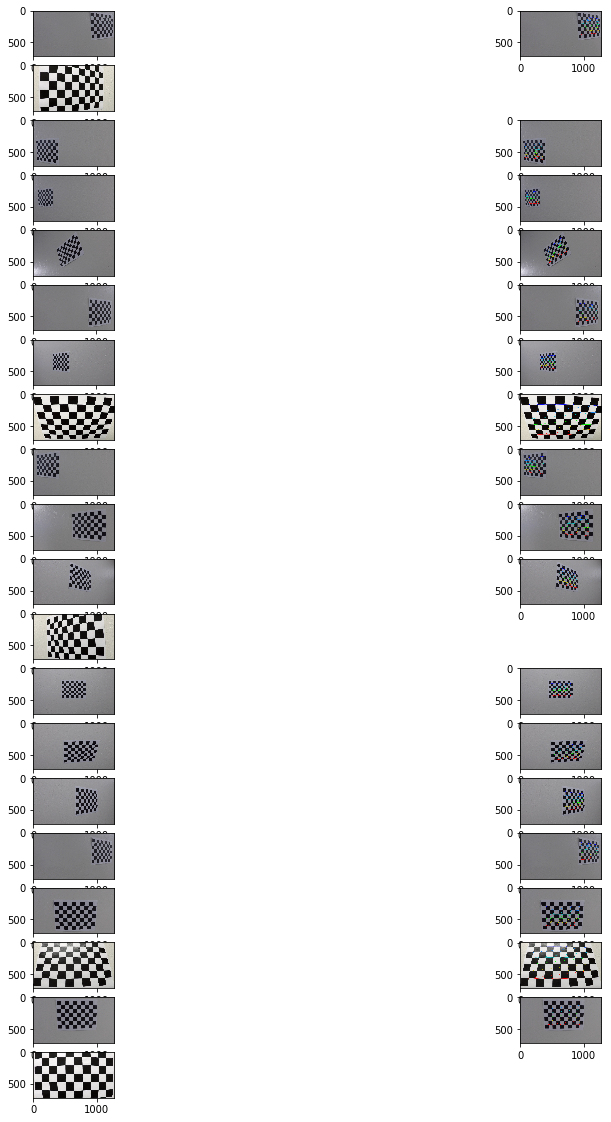

In [4]:
print("Calibrating Camera")
mtx, dist = calibrate_camera("camera_cal/", 20, 9, 6)

Undistorting Images


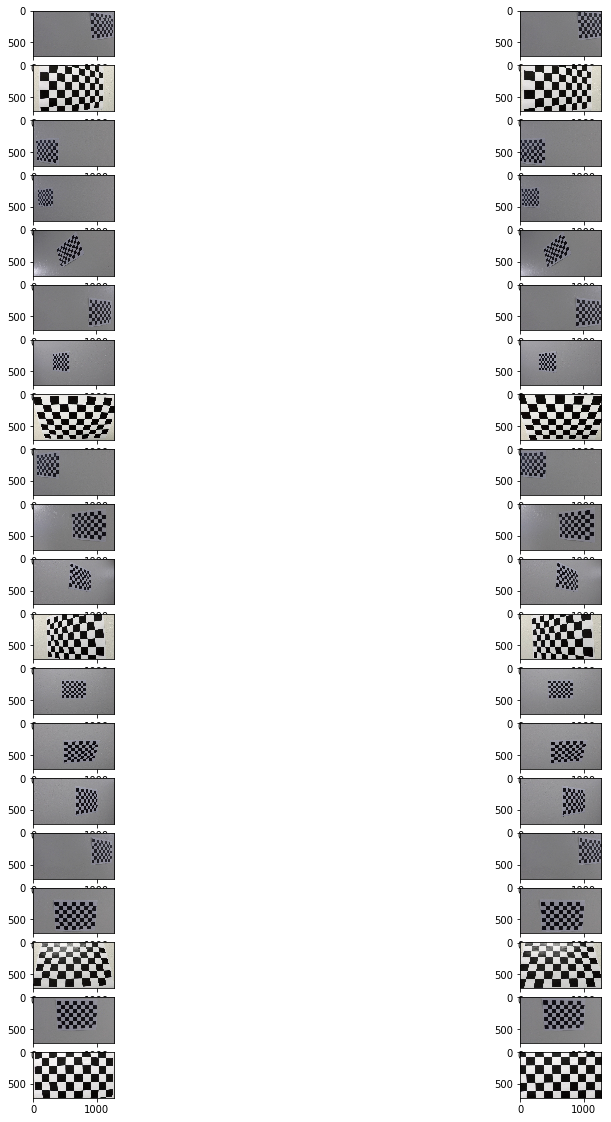

In [5]:
print("Undistorting Images")
undistort_images("camera_cal/", "camera_cal_undistorted/", 20, mtx, dist)

# Step 2: Threshold Images

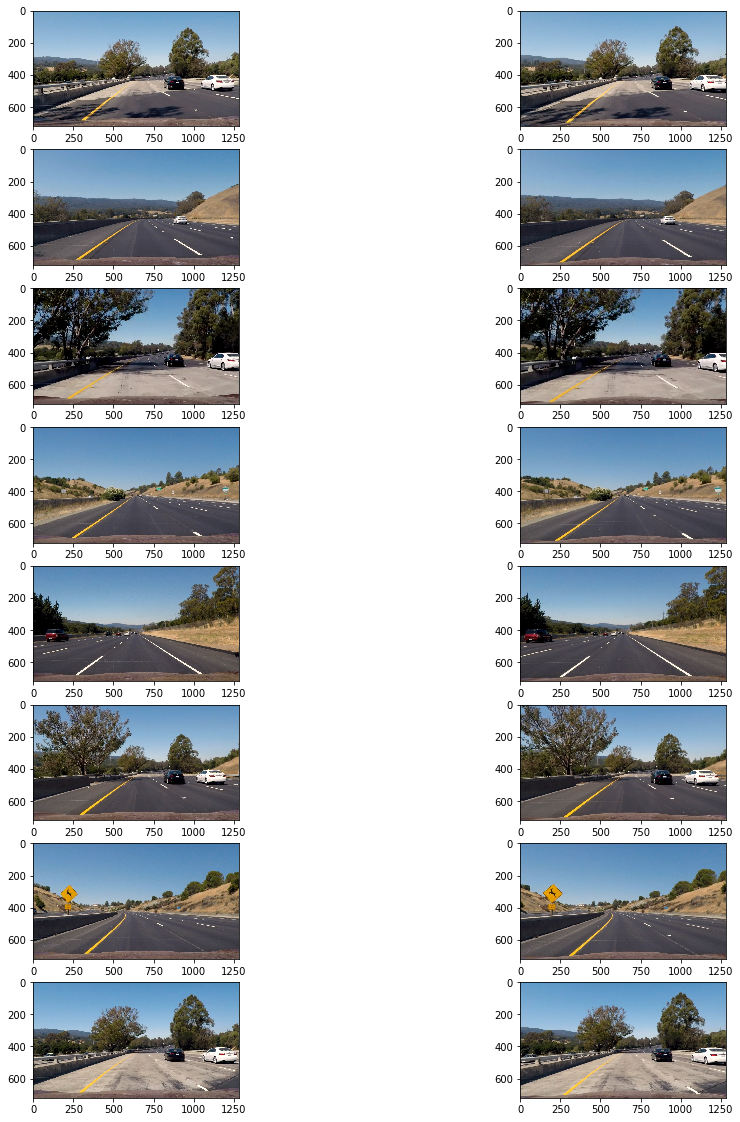

In [6]:
undistort_images("test_images/", "test_images_undistorted/", 8, mtx, dist)

In [7]:
# TODO: Add color thresholding here.
def threshold_img(img, thresh_min, thresh_max):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobel = np.absolute(sobel_x)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # added s thresholding to detect yellow lanes
    s_thresh_min = 170
    s_thresh_max = 255
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(s_binary == 1) | (sobel_binary == 1)] = 1
    
    return combined_binary

def abs_sobel_thresh(input_dir, output_dir, num_images, thresh_min, thresh_max):
    """ Outputs the thresholded images from input_dir to output_dir using the Sobel X operator.
    
    Parameters:
    ----------
    input_dir : str
        The directory containing the images to which Sobel thresholding will be applied.
    output_dir : str
        The directory containing the thresholded images.
    num_images : int
        The number of images in input_dir.
    thresh_min : int
        Minimum value of threshold [0, 255]
    thresh_max : int 
        Maximum value of threshold [0, 255]
    
    Returns
    -------
    tuple
        something?
     
    """
    fig = plt.figure(figsize=(16,20))
    cols = 2
    for img_number, img_name in enumerate(os.listdir(input_dir), start=1):
        img = mpimg.imread(input_dir + img_name)
        fig.add_subplot(num_images, cols, 2 * img_number - 1)
        plt.imshow(img)
        sobel_binary = threshold_img(img, thresh_min, thresh_max)
        fig.add_subplot(num_images, cols, 2 * img_number)
        plt.imshow(sobel_binary, cmap='gray')
        cv2.imwrite(output_dir + img_name, sobel_binary)
    
    

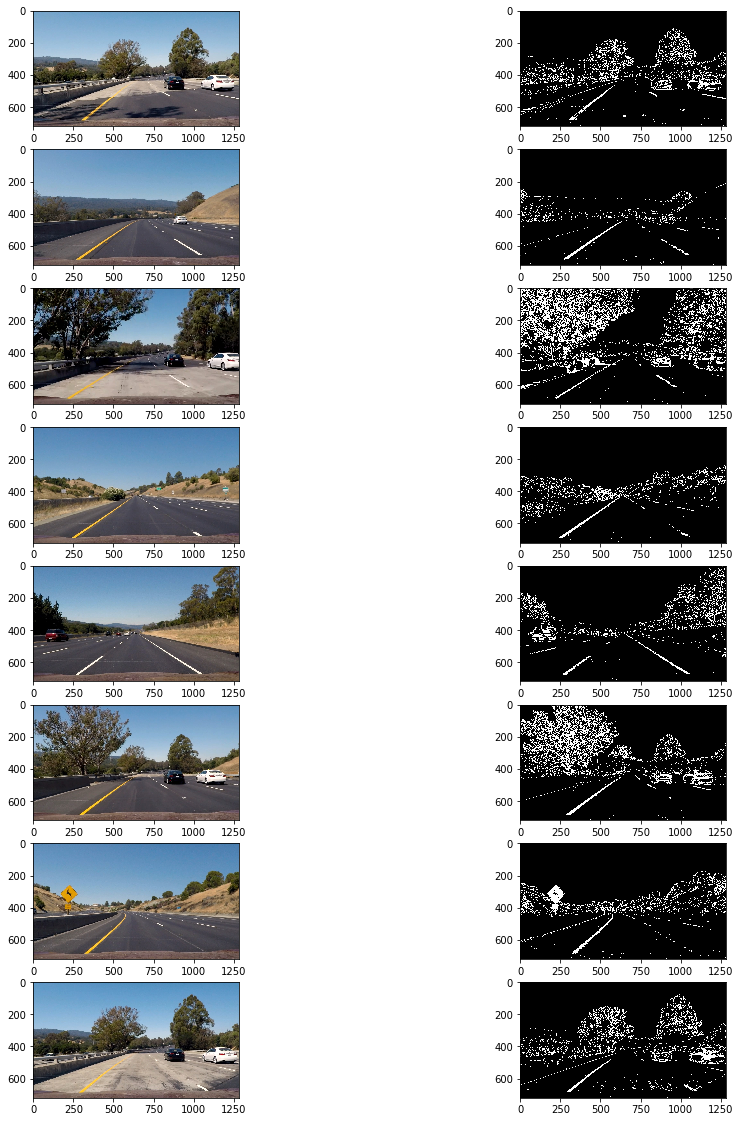

In [8]:
abs_sobel_thresh("test_images/", "test_images_sobel/", 8, 20, 100)

# Step 3: Perspective Transform

In [9]:
# assumes a 1280 x 720 picture
src = np.float32([[750, 450], [1100, 700], [250, 700], [600, 450]])
dst = np.float32([[1000, 0], [1000, 700], [300, 700], [300, 0]])
M = cv2.getPerspectiveTransform(src, dst)
def transform_img(img):
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

def perspective_transform(input_dir, output_dir, num_images): 
    fig = plt.figure(figsize=(16,20))
    cols = 2
    for img_number, img_name in enumerate(os.listdir(input_dir), start=1):
            img = mpimg.imread(input_dir + img_name)
            fig.add_subplot(num_images, cols, 2 * img_number - 1)
            plt.imshow(img, cmap='gray')

            warped = transform_img(img)
            fig.add_subplot(num_images, cols, 2 * img_number)
            plt.imshow(warped, cmap='gray')
            cv2.imwrite(output_dir + img_name, warped)
        


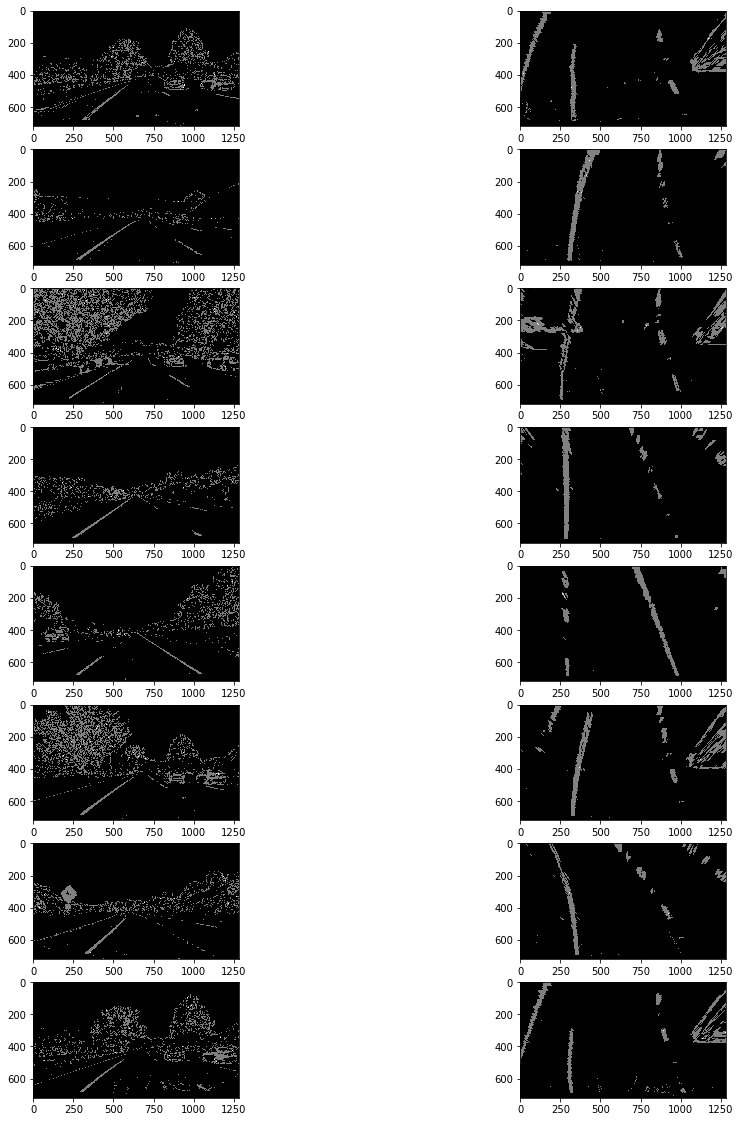

In [10]:
perspective_transform("test_images_sobel/", "test_images_perspective/", 8)

# Step 4: Identify Lane Lines

In [11]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 


        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = np.where((nonzerox >= win_xleft_low) &
                                  (nonzerox < win_xleft_high) &
                                  (nonzeroy >= win_y_low) &
                                  (nonzeroy < win_y_high))[0]
                                 
                                   
        good_right_inds = np.where((nonzerox >= win_xright_low) &
                                   (nonzerox < win_xright_high) &
                                   (nonzeroy >= win_y_low) &
                                   (nonzeroy < win_y_high))[0]
        
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.mean(nonzerox[good_left_inds],dtype=np.int)
        if len(good_right_inds) > minpix:
            rightx_current = np.mean(nonzerox[good_right_inds], dtype=np.int)

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [12]:
def fit_polynomial(binary_warped, ym_per_pix=1, xm_per_pix=1, debug=True):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, deg=2)
    right_fit = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, deg=2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    poly_fit = np.zeros_like(out_img)
    pts_left = np.vstack((left_fitx,ploty)).astype(np.int32).T
    cv2.polylines(poly_fit,  [pts_left],  False,  (0, 255, 0),  30)
    # plt.plot(left_fitx, ploty, color='yellow')
    pts_right = np.vstack((right_fitx,ploty)).astype(np.int32).T
    cv2.polylines(poly_fit,  [pts_right],  False,  (0, 255, 0),  30)
    # plt.plot(right_fitx, ploty, color='yellow')

    return poly_fit, left_fit, right_fit

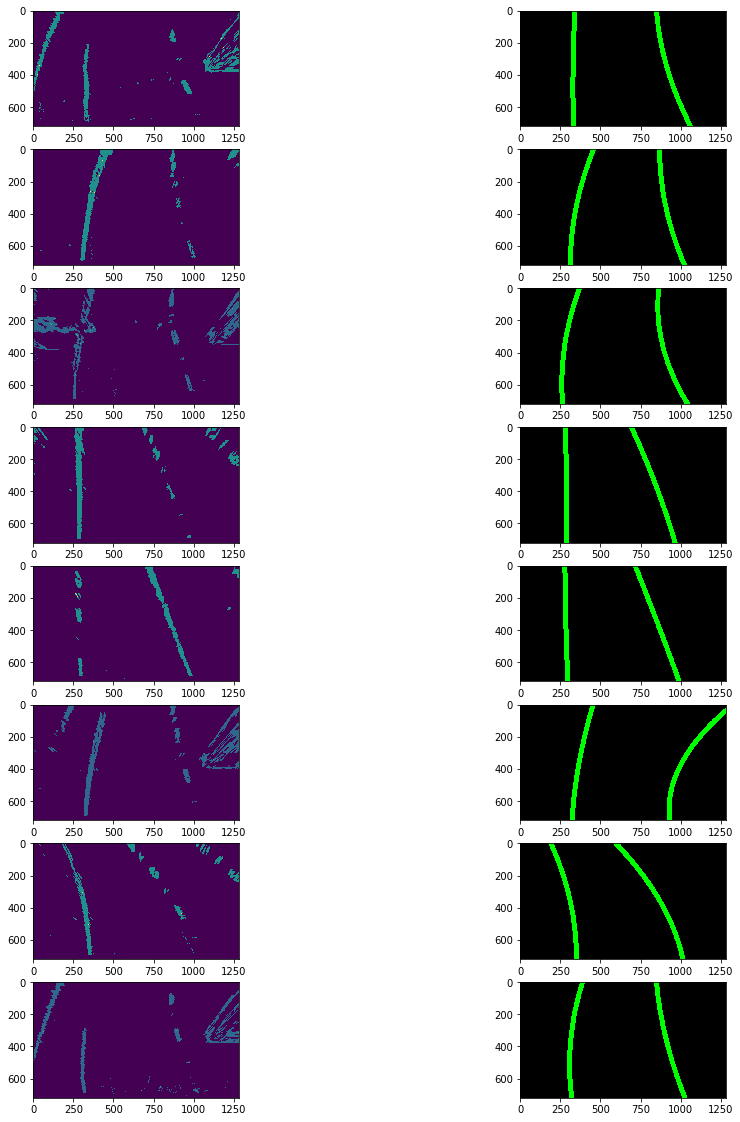

In [13]:
input_dir = "test_images_perspective/"
output_dir = "test_images_polynomial_fit/"
num_images = 8
cols = 2
fig = plt.figure(figsize=(16,20))
for img_number, img_name in enumerate(os.listdir(input_dir), start=1):
            img = mpimg.imread(input_dir + img_name)
            fig.add_subplot(num_images, cols, 2 * img_number - 1)
            plt.imshow(img)
            poly_fit_img, left_fit, right_fit = fit_polynomial(img)
            fig.add_subplot(num_images, cols, 2 * img_number)
            plt.imshow(poly_fit_img)
            cv2.imwrite(output_dir + img_name, poly_fit_img)


# Step 5: Calculate Radius of Curvature and Vehicle Position

In [14]:
def calc_curve(left_fit, right_fit, y_eval, ym_per_pix, xm_per_pix):
    left_curverad = int(np.power(1 + np.square(2 * left_fit[0] * y_eval * ym_per_pix + left_fit[1]), 1.5) / np.abs(2 * left_fit[0]))  ## Implement the calculation of the left line here
    right_curverad = int(np.power(1 + np.square(2 * right_fit[0] * y_eval * ym_per_pix + right_fit[1]), 1.5) / np.abs(2 * right_fit[0]))  ## Implement the calculation of the right line here
    return left_curverad, right_curverad

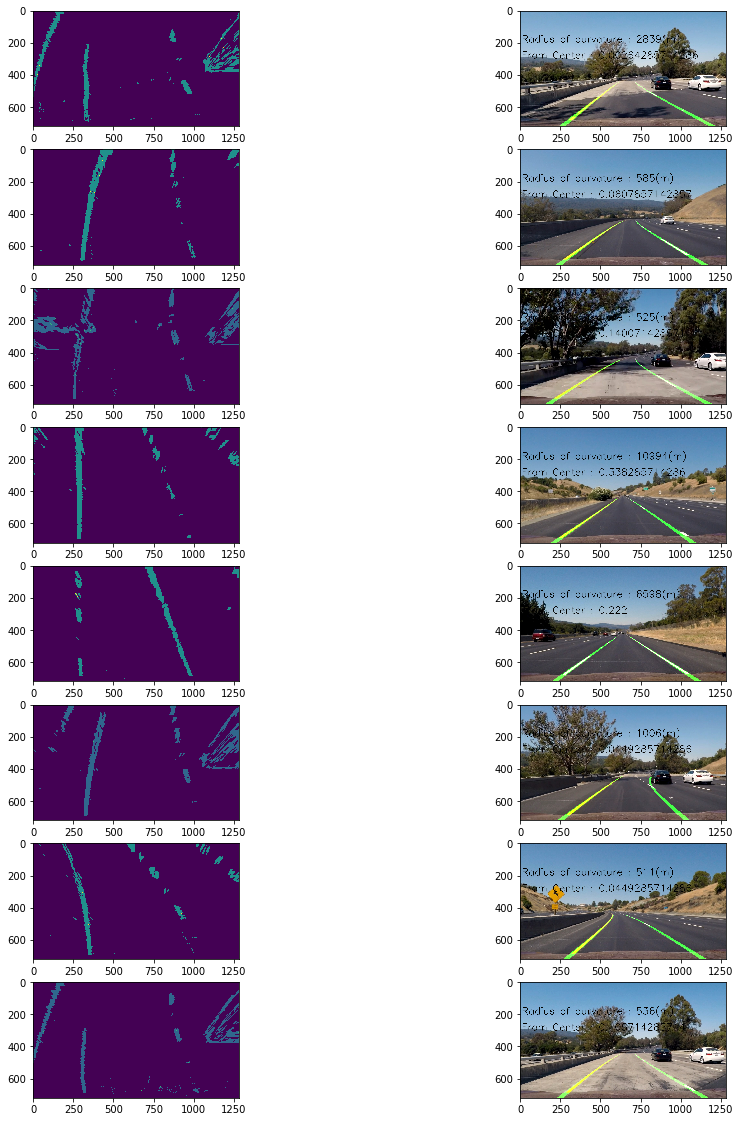

In [15]:
# TODO: Calculate the radius of curvature
original_dir = "test_images/"
input_dir = "test_images_perspective/"
output_dir = "test_images_curvature/"
num_images = 8
cols = 2
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
y_eval = 719 # Define y-value where we want radius of curvature
fig = plt.figure(figsize=(16,20))
# We'll choose the maximum y-value, corresponding to the bottom of the image
for img_number, img_name in enumerate(os.listdir(input_dir), start=1):
            img = mpimg.imread(input_dir + img_name)
            fig.add_subplot(num_images, cols, 2 * img_number - 1)
            plt.imshow(img)
            
            poly_fit_img_pix, left_fit_pix, right_fit_pix = fit_polynomial(img)
            # compute everything in meters
            poly_fit_img, left_fit, right_fit = fit_polynomial(img, ym_per_pix, xm_per_pix, debug=False)
            left_curverad, right_curverad = calc_curve(left_fit, right_fit, y_eval, ym_per_pix, xm_per_pix)
            src = np.float32([[750, 450], [1100, 700], [250, 700], [600, 450]])
            dst = np.float32([[1000, 0], [1000, 700], [300, 700], [300, 0]])
            Minv = cv2.getPerspectiveTransform(dst, src)
            img_size = (img.shape[1], img.shape[0])
            warped = cv2.warpPerspective(poly_fit_img_pix, Minv, img_size, flags=cv2.INTER_LINEAR)
            #cv2.putText(warped, "Radius of curvature : " + str(left_curverad), (10,200), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
            histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
            # Find the peak of the left and right halves of the histogram
            # These will be the starting point for the left and right lines
            midpoint = np.int(histogram.shape[0]//2)
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint
            # calculate how far from center the car is
            position = abs(((leftx_base + rightx_base) / 2) - midpoint) * xm_per_pix
            fig.add_subplot(num_images, cols, 2 * img_number)
            original_img = mpimg.imread(original_dir + img_name)
            cv2.putText(original_img, "Radius of curvature : " + str(left_curverad) + "(m)", (10,200), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 2, cv2.LINE_AA)
            cv2.putText(original_img, "From Center : " + str(position), (10,300), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 2, cv2.LINE_AA)
            result = cv2.addWeighted(original_img, 1, warped, 2, 0)
            plt.imshow(result)
            cv2.imwrite(output_dir + img_name, result)


# Run Pipeline on Video

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [18]:
def unwarp_img(img):
    src = np.float32([[750, 450], [1100, 700], [250, 700], [600, 450]])
    dst = np.float32([[1000, 0], [1000, 700], [300, 700], [300, 0]])
    Minv = cv2.getPerspectiveTransform(dst, src)
    img_size = (img.shape[1], img.shape[0])
    unwarped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    return unwarped

In [19]:
def process_image(img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    undistorted_img = undistort_img(img, mtx, dist)
    thresholded_img = threshold_img(undistorted_img, thresh_min=20, thresh_max=100)
    transformed_img = transform_img(thresholded_img)
    poly_fit_img, left_fit, right_fit = fit_polynomial(transformed_img)
    # fit for radius of curvature in meters
    poly_fit_img_cr, left_fit_cr, right_fit_cr = fit_polynomial(transformed_img, ym_per_pix, xm_per_pix, debug=False)
    left_curverad, right_curverad = calc_curve(left_fit, right_fit, y_eval, ym_per_pix, xm_per_pix)
    unwarped = unwarp_img(poly_fit_img)
    histogram = np.sum(transformed_img[transformed_img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # calculate how far from center the car is
    position = abs(((leftx_base + rightx_base) / 2) - midpoint) * xm_per_pix
    cv2.putText(img, "Radius of curvature : " + str(left_curverad) + "(m)", (10,200), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 2, cv2.LINE_AA)
    cv2.putText(img, "From Center : " + str(position), (10,300), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 2, cv2.LINE_AA)
    result = cv2.addWeighted(img, 1, unwarped, 2, 0)
    
    return result

In [20]:
white_output = 'test_videos_result/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("project_video.mp4").subclip(0, 5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
# clip1.close()

[MoviePy] >>>> Building video test_videos_result/project_video.mp4
[MoviePy] Writing video test_videos_result/project_video.mp4


100%|█████████▉| 1260/1261 [04:45<00:00,  4.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_result/project_video.mp4 

CPU times: user 2min 29s, sys: 1.5 s, total: 2min 30s
Wall time: 4min 48s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

# Run on Challenge Video (not very good)

In [69]:
challenge_output = 'test_videos_result/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("challenge_video.mp4").subclip(0, 5)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(challenge_output, audio=False)
# clip1.close()

[MoviePy] >>>> Building video test_videos_result/challenge_video.mp4
[MoviePy] Writing video test_videos_result/challenge_video.mp4


100%|██████████| 485/485 [01:45<00:00,  4.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_result/challenge_video.mp4 

CPU times: user 51.9 s, sys: 4.96 s, total: 56.8 s
Wall time: 1min 48s


In [58]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))